# DETEKSI PENGEMUDI MENGANTUK MENGGUNAKAN METODE CNN DAN OPENCV

In [4]:
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [24]:
# Import dataset berupa image lalu resize supaya ukurannya sama 
# untuk pojek ini, resize menjadi 145x145 pixels
# berikut fungsi import sederhana menggunakan library OS

def load_images_from_folder(folder, eyes = 0):
    count = 0
    error_count = 0
    images = []
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder,filename))
            img = cv2.resize(img, (80,80))
            # eyes 0: open, 1: close
            images.append([img, eyes])
        except:
            error_count += 1
            print('Error = ' + str(error_count))
            continue
        
        count += 1
        if count % 100 == 0:
            print(' Berhasil import gambar dari folder '+folder+' sebanyak = '+str(count))

    return images

folder="data/Open"
open_eyes = load_images_from_folder(folder, 0)

folder="data/Closed"
closed_eyes = load_images_from_folder(folder, 1)
eyes = closed_eyes + open_eyes

 Berhasil import gambar dari folder data/Open sebanyak = 100
 Berhasil import gambar dari folder data/Closed sebanyak = 100


In [3]:
# Atur variabel x sebagai fitur gambar, dan y sebagai label yang sesuai (1:close, 0:open)
X = [] 
y = [] 
for features, label in eyes: 
     X.append(features)
     y.append(label)

In [4]:
# Ubah gambar menjadi array untuk masuk ke model lalu skalakan data dengan membaginya dengan 255.
X = np.array(X).reshape(-1, 80, 80, 3)
y = np.array(y)
X = X/255.0

In [5]:
# Pisahkan data menjadi train set dan validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

In [6]:
# Membuat model
model = Sequential()

# Menambahkan empat lapisan konvolusi pertama dan pooling untuk setiap layer
model.add(Conv2D(
                filters = 256, # jumlah filter
                kernel_size = (3,3), # tinggi dan lebar filter
                activation = 'relu', # fungsi aktivasi 
                input_shape = (80,80,3) # ukuran input (gambar)
                ))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(
                filters = 128, # jumlah filter
                kernel_size = (3,3), # tinggi dan lebar filter
                activation = 'relu' # fungsi aktivasi
                ))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(
                filters = 64, # jumlah filter
                kernel_size = (3,3), # tinggi dan lebar filter
                activation = 'relu' # fungsi aktivasi 
                ))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(
                filters = 32, # jumlah filter
                kernel_size = (3,3), # tinggi dan lebar filter
                activation = 'relu' # fungsi aktivasi
                ))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))

# menambahkan output layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=[tf.keras.metrics.AUC(curve = 'PR')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          1

In [7]:
# fitting model
history = model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=16)

# mengevaluasi model
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/16
5/5 [==============================] - 17s 3s/step - loss: 0.6940 - auc: 0.4557 - val_loss: 0.6928 - val_auc: 0.5450
Epoch 2/16
5/5 [==============================] - 18s 4s/step - loss: 0.6921 - auc: 0.5314 - val_loss: 0.6894 - val_auc: 0.6860
Epoch 3/16
5/5 [==============================] - 20s 4s/step - loss: 0.6809 - auc: 0.6397 - val_loss: 0.6907 - val_auc: 0.7018
Epoch 4/16
5/5 [==============================] - 21s 4s/step - loss: 0.6681 - auc: 0.6207 - val_loss: 0.6837 - val_auc: 0.8050
Epoch 5/16
5/5 [==============================] - 22s 4s/step - loss: 0.6312 - auc: 0.6542 - val_loss: 0.5899 - val_auc: 0.9438
Epoch 6/16
5/5 [==============================] - 21s 4s/step - loss: 0.6242 - auc: 0.6962 - val_loss: 0.5869 - val_auc: 0.7975
Epoch 7/16
5/5 [==============================] - 22s 4s/step - loss: 0.6025 - auc: 0.6999 - val_loss: 0.5406 - val_auc: 0.9758
Epoch 8/16
5/5 [==============================] - 22s 4s/step - loss: 0.5465 - auc: 0.8305 - val_loss: 0

[0.10505834221839905, 0.9936355352401733]

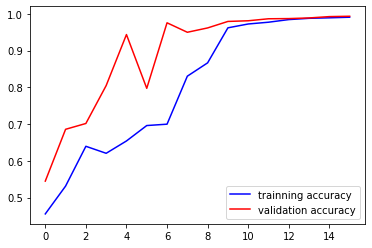

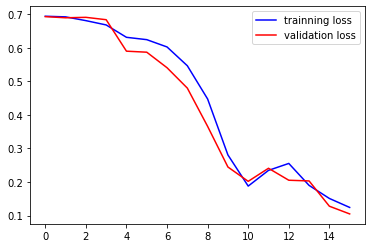

In [8]:
# melihat plot history
accuracy = history.history['auc']
val_accuracy = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [9]:
# simpan model
model.save("megi_CNN.h5")

In [6]:
# Menangkap setiap frame dengan OpenCV dan crop pada bagian mata
eye_model = keras.models.load_model('megi_CNN.h5')

# memasukkan frame webcame ke fungsi
def eye_cropper(frame):

    # membuat variabel untuk facial feature coordinates
    facial_features_list = face_recognition.face_landmarks(frame)

    # buat daftar placeholder untuk koordinat mata
    # dan tambahkan koordinat mata ke daftar
    # tidak ditemukan dengan pengenalan wajah
    try:
        eye = facial_features_list[0]['left_eye']
    except:
        try:
            eye = facial_features_list[0]['right_eye']
        except:
            return
    
    # tentukan koordinat maks x dan y mata
    x_max = max([coordinate[0] for coordinate in eye])
    x_min = min([coordinate[0] for coordinate in eye])
    y_max = max([coordinate[1] for coordinate in eye])
    y_min = min([coordinate[1] for coordinate in eye])

    # tentukan jangkauan koordinat x dan y
    x_range = x_max - x_min
    y_range = y_max - y_min

    # untuk memastikan mata penuh ditangkap, 
    # hitung koordinat bujur sangkar yang memiliki cushion 50% 
    # yang ditambahkan ke sumbu dengan rentang yang lebih besar,
    # lalu cocokkan rentang yang lebih kecil dengan rentang yang lebih luas.
    
    if x_range > y_range:
        right = round(.5*x_range) + x_max
        left = x_min - round(.5*x_range)
        bottom = round((((right-left) - y_range))/2) + y_max
        top = y_min - round((((right-left) - y_range))/2)
    else:
        bottom = round(.5*y_range) + y_max
        top = y_min - round(.5*y_range)
        right = round((((bottom-top) - x_range))/2) + x_max
        left = x_min - round((((bottom-top) - x_range))/2)

    # potong image sesuai dengan koordinat yang ditentukan di atas
    cropped = frame[top:(bottom + 1), left:(right + 1)]

    # resize image
    cropped = cv2.resize(cropped, (80,80))
    image_for_prediction = cropped.reshape(-1, 80, 80, 3)

    return image_for_prediction

# inisiasi webcam dengan openCV
cap = cv2.VideoCapture(0)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
if not cap.isOpened():
    raise IOError('Cannot open webcam')

# set counter
counter = 0

# while loop akan terus berjalan sampai camera selesai digunakan
while True:

    # menangkap frame dari webcam
    ret, frame = cap.read()
    
    frame_count = 0
    if frame_count == 0:
        frame_count += 1
        pass
    else:
        count = 0
        continue

    # memanggil fungsi pada frame untuk mengambil hanya bagian mata dari frame,
    # jika tidak dapat menemukan mata dalam frame, fungsi akan mengembalikan 'None' 
    # yang tidak dapat dibagi dengan 255 dan akan melompat ke frame selanjutnya.
    image_for_prediction = eye_cropper(frame)
    try:
        image_for_prediction = image_for_prediction/255.0
    except:
        continue

    # Prediksi dari model
    prediction = eye_model.predict(image_for_prediction)
    cv2.putText(frame, str(prediction), (17,57), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),2)
    
    # Berdasarkan prediksi, tampilkan "Mata Terbuka" atau "Mata Tertutup"
    if prediction > 0.3:
        counter = 0
        status = 'Open'

        cv2.putText(frame, status, (round(w/2)-80,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_4)
        cv2.putText(frame, 'Active', (17,37), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
    else:
        counter = counter + 1
        status = 'Close'

        cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_4)
        cv2.putText(frame, 'Active', (17,37), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)

        # Jika nilai counter lebih dari 2, tampilkan peringatan untuk pengguna
        if counter > 5:
            cv2.rectangle(frame, (round(w/2) - 160, round(h) - 200), (round(w/2) + 160, round(h) - 120), (0,0,255), -1)
            cv2.putText(frame, 'DRIVER SLEEP', (round(w/2)-136,round(h) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_4)
            cv2.imshow('Drowsiness Detection', frame)
            k = cv2.waitKey(1)
            counter = 1
            continue
            
    # tekan ESC untuk keluar 
    cv2.imshow('Drowsiness Detection', frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

Saat nilai prediksi di atas 3
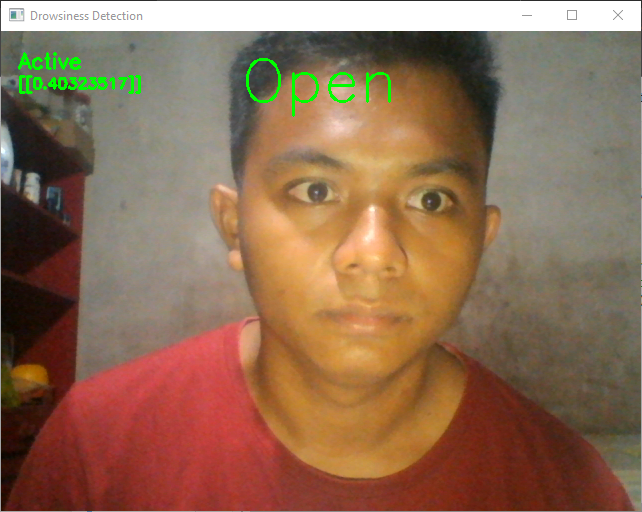

Saat nilai prediksi dibawah 3
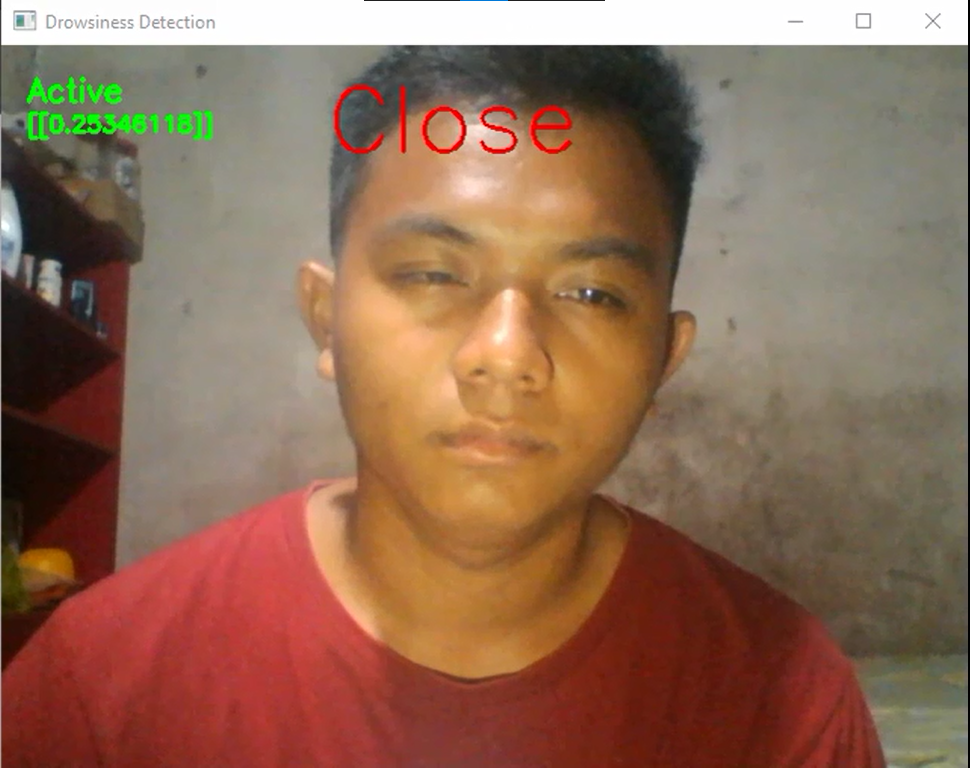